<a href="https://colab.research.google.com/github/kylemcq13/Projects/blob/master/18_3_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting House Prices Assignment

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.

In [0]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [0]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [0]:
#preview the dataset
houses_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


# Data Exploration

In [0]:
houses_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [0]:
#check the dataset
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

We have numeric and non numeric values within our data set. Since we are building a regression model, if we want to use a non numeric feature it will need to be converted to a numeric feature. Something to keep in mind.

Let's now look for missing data.

In [0]:
#houses_df.isnull().sum()*100/houses_df.isnull().count()

In [0]:
total_missing = houses_df.isnull().sum().sort_values(ascending=False)
percent_missing = (houses_df.isnull().sum()/houses_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


We do have missing values within the dataset but most columns are completely full. For now, I will not use the features with missing values.

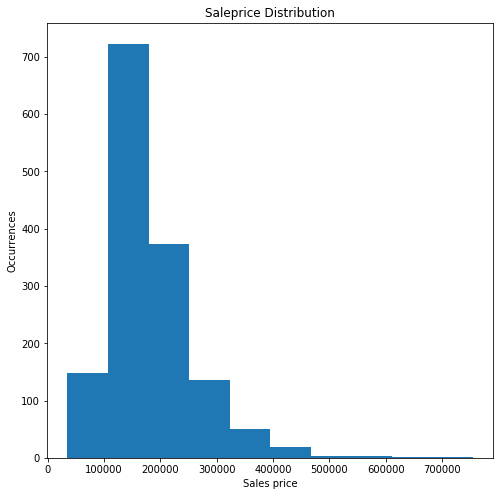

In [0]:
#let's take a look at our target variable distribution, saleprice

plt.figure(figsize=(8,8))
plt.hist(houses_df.saleprice)
plt.title("Saleprice Distribution")
plt.xlabel("Sales price")
plt.ylabel("Occurrences")
plt.show()

The data is skewed to the right, showing non normal distribution. Most sale prices fall within the 100k - 200k range.

# Feature Selection

In [0]:
#plot a correlation matrix
pd.set_option('display.max_columns', None)
houses_df.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
lotarea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
bsmtfinsf1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303

In [0]:
#with the above being tough to analyze, lets make a list of the top correlated features with saleprice
np.abs(houses_df.corr().loc["saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
id               0.021917
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: salepr

Looking at our list above, we can see that 'overallqual', 'grlivarea', 'garagecars', 'garagearea', and 'totalbsmtsf' are the most strongly correlated features with salesprice. 

In [0]:
#we've looked at our numeric column correlations above, but what about the non numeric columns?

non_numeric_columns = houses_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


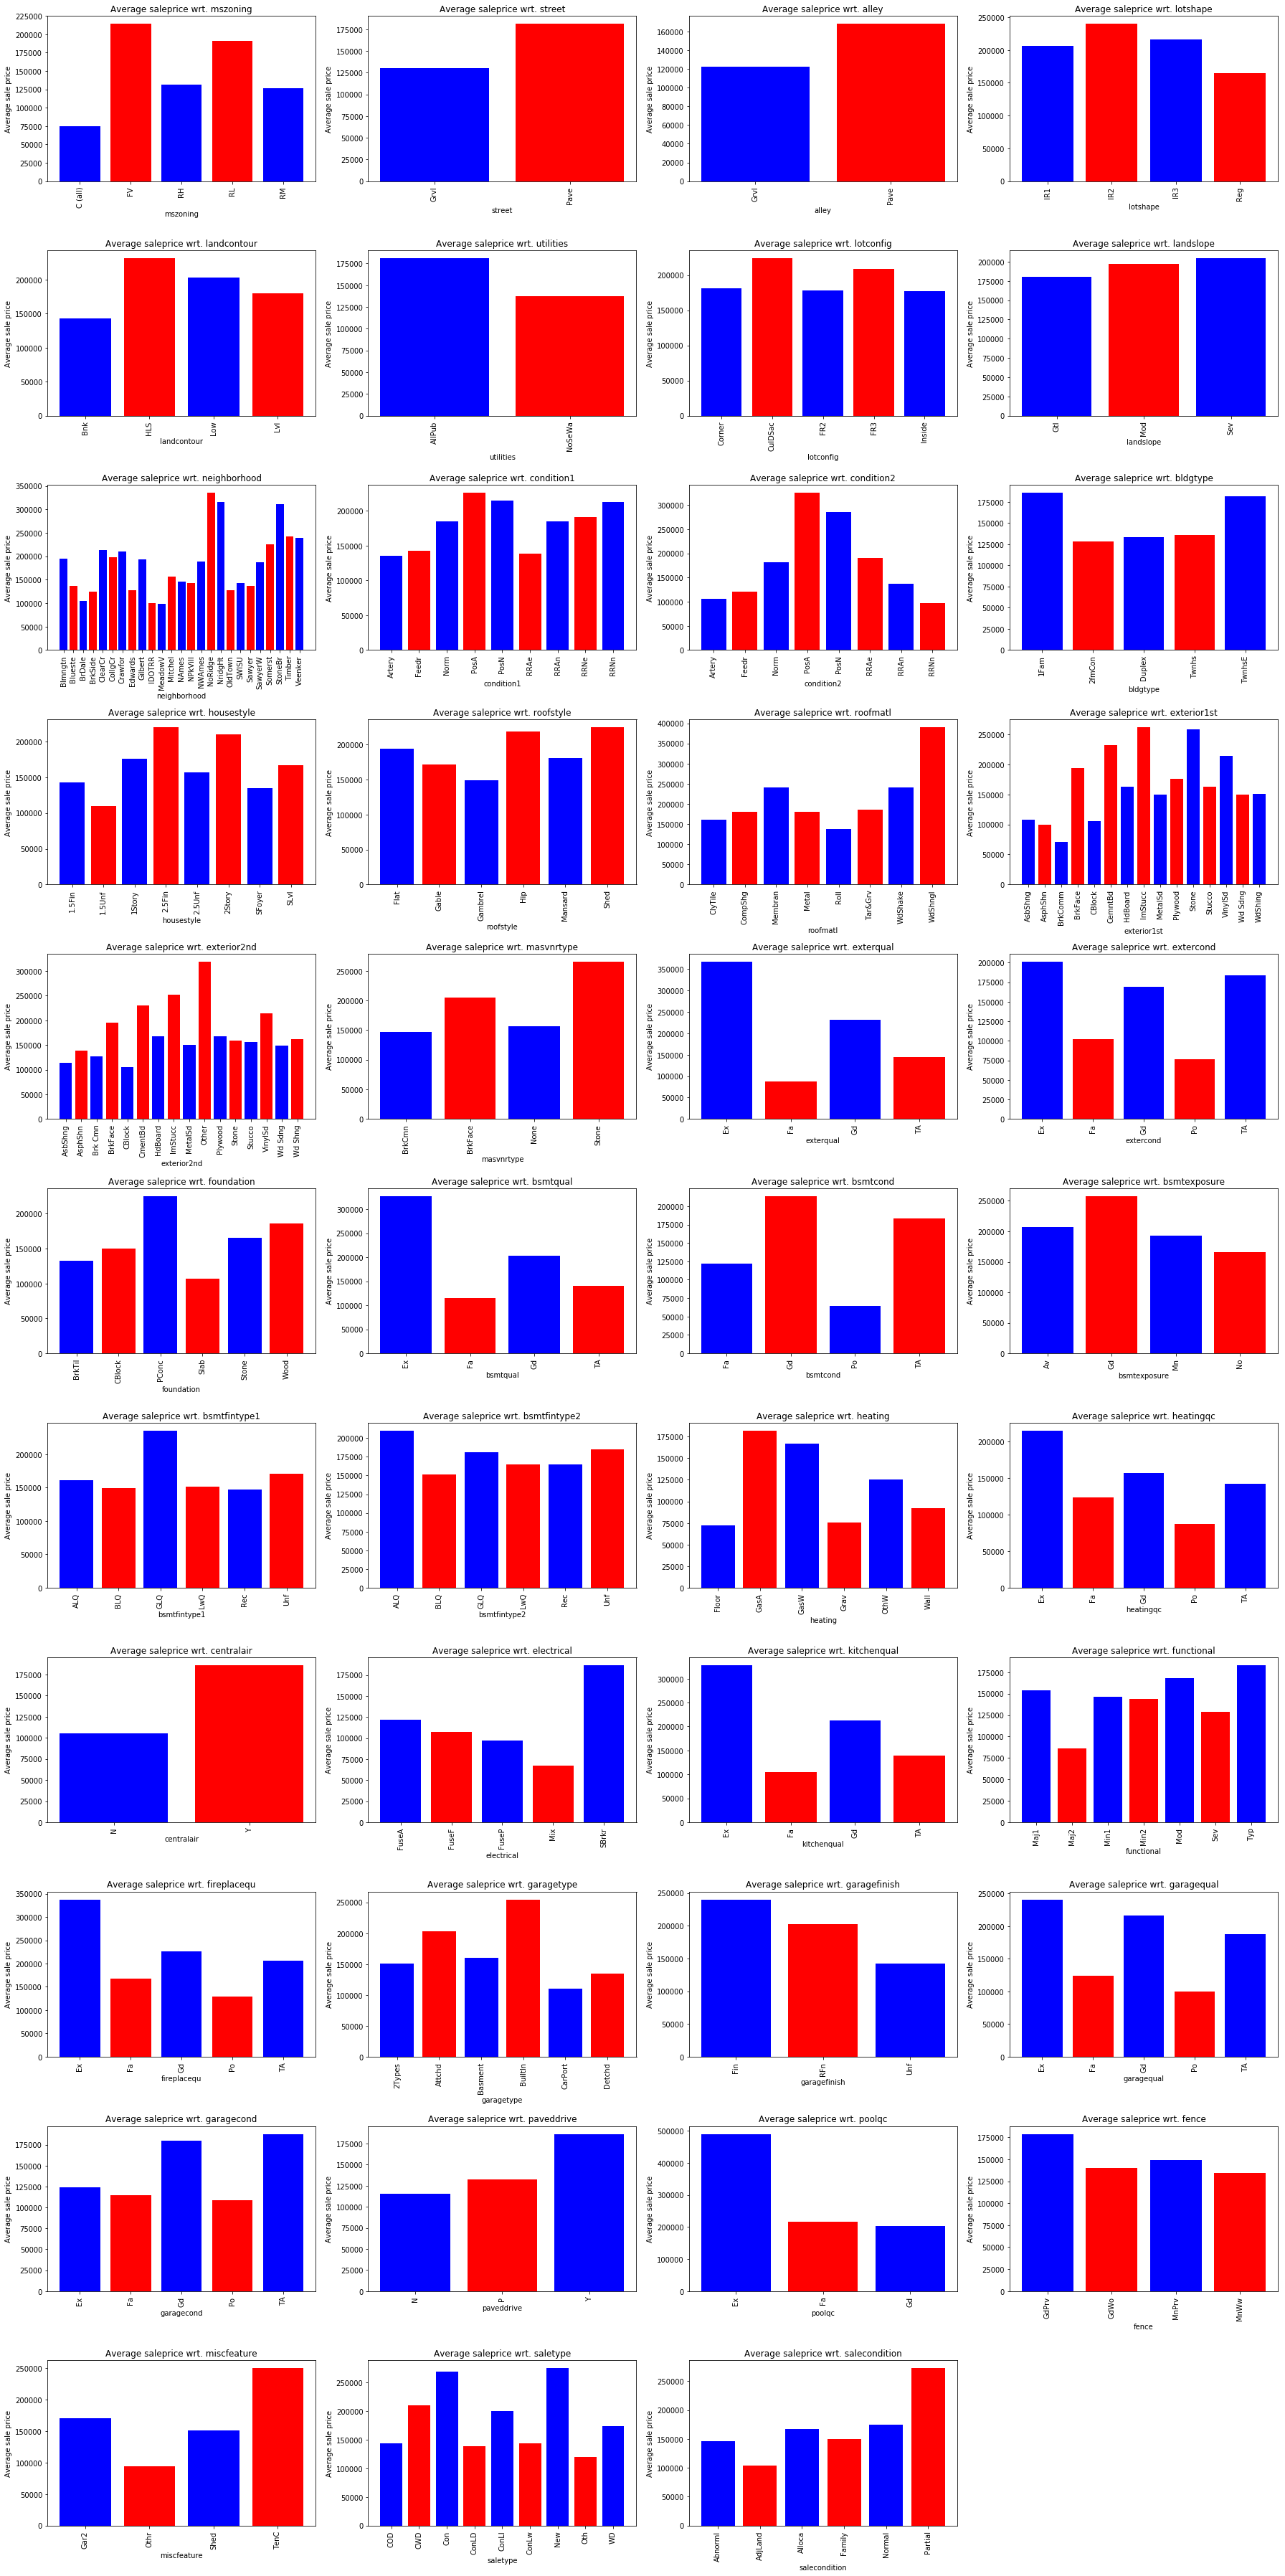

In [0]:
#is there a better way to evaluate the non numeric columns than simple bar graphs?

plt.figure(figsize=(25,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(houses_df.groupby(column)["saleprice"].mean().index, houses_df.groupby(column)["saleprice"].mean(),
           color=("blue","red"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

We see some variance in quite a few non numeric variables in the above subplot. For the sake of this assignment, let's pick three variables to add to our model. Mszoning, street and kitchenqual seem like interesting features to add.

In [0]:
#convert to numeric and add our categorical variables back to our dataframe

houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.street, prefix="street", drop_first=True)], axis=1)
houses_df = pd.concat([houses_df,pd.get_dummies(houses_df.street, prefix="kitchenqual", drop_first=True)], axis=1)

cat_column_names = list(pd.get_dummies(houses_df.mszoning, prefix="mszoning", drop_first=True).columns)
cat_column_names = cat_column_names + list(pd.get_dummies(houses_df.street, prefix="street", drop_first=True).columns)
cat_column_names2 = cat_column_names + list(pd.get_dummies(houses_df.street, prefix="kitchenqual", drop_first=True).columns)

# Our Regression Model

In [0]:
# Y is the target variable
Y = houses_df['saleprice']
# X is the feature set which includes
X = houses_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']  + cat_column_names2]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
np.set_printoptions(suppress=True)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [23326.53528104    45.63435654 13450.13639005    16.40820478
    28.3816393  25087.51373633 13420.45640209 28565.85602401
  9047.78935559    75.51881094    75.51881094]

Intercept: 
 -117337.72871399325


In [0]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     482.0
Date:                Mon, 11 Nov 2019   Prob (F-statistic):               0.00
Time:                        09:42:17   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.173e+05    1.8e+04     -6.502      0.000   -1.53e+05   -8.19e+04
overallqual       2.333e+04   1088.506     21.430      0.000    2.12e+04    2.55e+04
grlivarea           45.6344      2.468     18.494      0.000      40.794      50.475
garagecars        1.345e+04   2990.453      4.498      0.000    7584.056    1.93e+04
garagearea          16.4082     10.402      1.577      0.115      -3.997      36.813
totalbsmtsf         28.3816      2.931      9.684      0.000      22.633      34.131
mszoning_FV       2.509e+04   1.37e+04      1.833      0.067   -1761.679    5.19e+04
mszoning_RH       1.342e+04   1.58e+04      0.847      0.397   -1.77e+04    4.45e+04
mszoning_RL       2.857e+04   1.27e+04      2.246      0.025    3612.782    5.35e+04
mszoning_RM       9047.7894   1.29e+04      0.702      0.483   -1.62e+04    3.43e+04
street_Pave         75.5188   8145.750      0.009      0.993   -1.59e+04    1.61e+04
kitchenqual_Pave    75.5188   8145.750      0.009      0.993   -1.59e+04    1.61e+04
==============================================================================
Omnibus:                      415.883   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41281.526
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                      29.049   Cond. No.                     1.24e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.81e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 1. Linearity of the model in its coefficients

Again, we are using a model that takes into account a linearity assumption, therefore we shouldn't worry about this assumption in this situation.

# 2. The error term should be zero on average

In [0]:
X = houses_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']  + cat_column_names2]
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -9.787658050860444e-12


# 3. Homoscedasticity

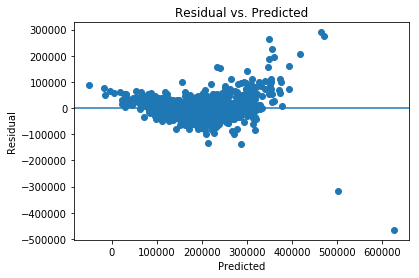

In [0]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [0]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 497.754 and p value is 2.93e-110
Levene test statistic value is 491.982 and p value is 7.29e-101


Based on the p values, it looks as if the errors are heteroscedastic. This could possibly be fixed by dealing with the outliers in the dataset or transforming the target variable.

# 4. Low multicollinearity

In [0]:
#how low exactly should our correlations be? In our correlation table below, which would raise flags? 
#when we see high multicollinearity, how do we go about fixing? PCA? grouping?
X.corr()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,kitchenqual_Pave
overallqual,1.000000,0.593007,0.600671,0.562022,0.537808,0.171854,-0.064666,0.126972,-0.195515,0.058823,0.058823
grlivarea,0.593007,1.000000,0.467247,0.468997,0.454868,0.024275,-0.001070,0.132936,-0.154239,0.044121,0.044121
garagecars,0.600671,0.467247,1.000000,0.882475,0.434585,0.102851,-0.090477,0.175167,-0.221834,-0.020025,-0.020025
garagearea,0.562022,0.468997,0.882475,1.000000,0.486665,0.114859,-0.073188,0.169593,-0.235580,-0.047794,-0.047794
totalbsmtsf,0.537808,0.454868,0.434585,0.486665,1.000000,-0.032689,-0.055128,0.257373,-0.247379,0.005068,0.005068
mszoning_FV,0.171854,0.024275,0.102851,0.114859,-0.032689,1.000000,-0.022722,-0.416608,-0.090435,0.013866,0.013866
mszoning_RH,-0.064666,-0.001070,-0.090477,-0.073188,-0.055128,-0.022722,1.000000,-0.203158,-0.044101,0.006762,0.006762
mszoning_RL,0.126972,0.132936,0.175167,0.169593,0.257373,-0.416608,-0.203158,1.000000,-0.808585,0.045348,0.045348
mszoning_RM,-0.195515,-0.154239,-0.221834,-0.235580,-0.247379,-0.090435,-0.044101,-0.808585,1.000000,-0.003127,-0.003127
street_Pave,0.058823,0.044121,-0.020025,-0.047794,0.005068,0.013866,0.006762,0.045348,-0.003127,1.000000,1.000000


It looks as if we have some correlation between some of our variables. Grouping these together with the PCA technique could help here. 

# 5. Error terms should be uncorrelated with one another


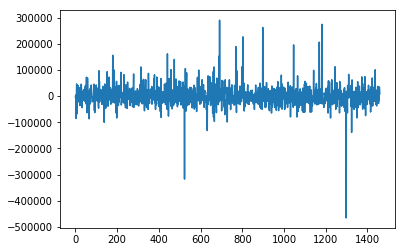

In [0]:
plt.plot(errors)
plt.show()

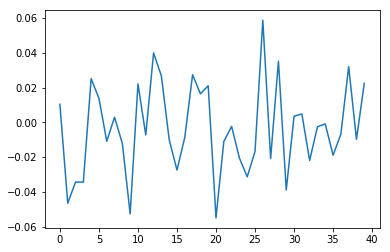

In [0]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Neither of our plots have a clear pattern so it looks as if our errors are not correlated here.

# 6. Features shouldn't be correlated with the errors


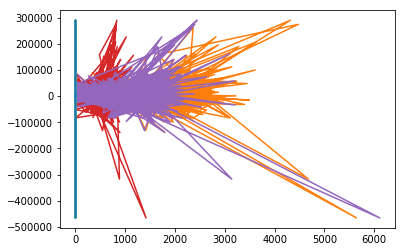

In [0]:
#again, what is the best way to go about analyzing for this? What is the best test?

plt.plot(X, errors)

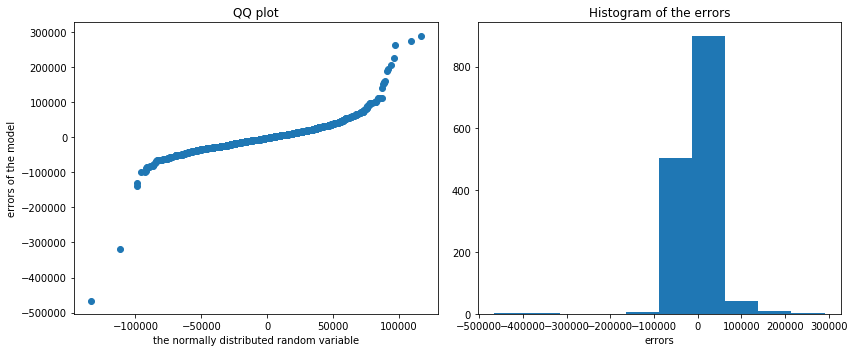

In [0]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [0]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 41281.52601826371 and p value is 0.0
Normality test statistics is 415.8826568586244 and p value is 4.92298489808015e-91


We can clearly see that our error data is not normally distributed. According to the module, more of often than not, this is because of an omitted variable. Transorming the target variable could also help in this case.